In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Importing Sunspot dataset
data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
df = pd.read_csv(data_url)
df.set_index('Month', inplace=True)
sunspots = df['Sunspots'].values.reshape(-1, 1)

In [13]:
# Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
sunspots_scaled = scaler.fit_transform(sunspots)

In [14]:
# Function to create time series dataset
def create_time_series_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [15]:
# Setting parameters
window_size = 12  # Window size for time series data
batch_size = 32  # Batch size
shuffle_buffer_size = 1000  # Shuffle buffer size

# Creating time series dataset
X, y = create_time_series_dataset(sunspots_scaled, window_size)

# Splitting data into training and validation sets
train_size = int(0.8 * len(X))
train_dataset = tf.data.Dataset.from_tensor_slices((X[:train_size], y[:train_size]))
val_dataset = tf.data.Dataset.from_tensor_slices((X[train_size:], y[train_size:]))

# Shuffling and batching the datasets
train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [23]:
# Building a model
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same', input_shape=(window_size, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GRU(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GRU(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

In [24]:
# Implementing Early Stopping and Model Checkpoint
early_stopping = EarlyStopping(patience=10, monitor='val_loss')
model_checkpoint = ModelCheckpoint('best_model_weights.h5', save_best_only=True, save_weights_only=True)

# Training the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=200, callbacks=[early_stopping, model_checkpoint])

Epoch 1/200
71/71 [==============================] - 12s 67ms/step - loss: 0.3652 - val_loss: 0.4383
Epoch 2/200
71/71 [==============================] - 3s 38ms/step - loss: 0.3298 - val_loss: 0.3993
Epoch 3/200
71/71 [==============================] - 4s 55ms/step - loss: 0.3054 - val_loss: 0.3625
Epoch 4/200
71/71 [==============================] - 3s 38ms/step - loss: 0.2816 - val_loss: 0.3285
Epoch 5/200
71/71 [==============================] - 3s 42ms/step - loss: 0.2611 - val_loss: 0.2911
Epoch 6/200
71/71 [==============================] - 4s 60ms/step - loss: 0.2427 - val_loss: 0.2642
Epoch 7/200
71/71 [==============================] - 3s 48ms/step - loss: 0.2245 - val_loss: 0.2331
Epoch 8/200
71/71 [==============================] - 3s 39ms/step - loss: 0.2096 - val_loss: 0.2071
Epoch 9/200
71/71 [==============================] - 4s 53ms/step - loss: 0.1944 - val_loss: 0.1907
Epoch 10/200
71/71 [==============================] - 3s 42ms/step - loss: 0.1813 - val_loss: 0.176

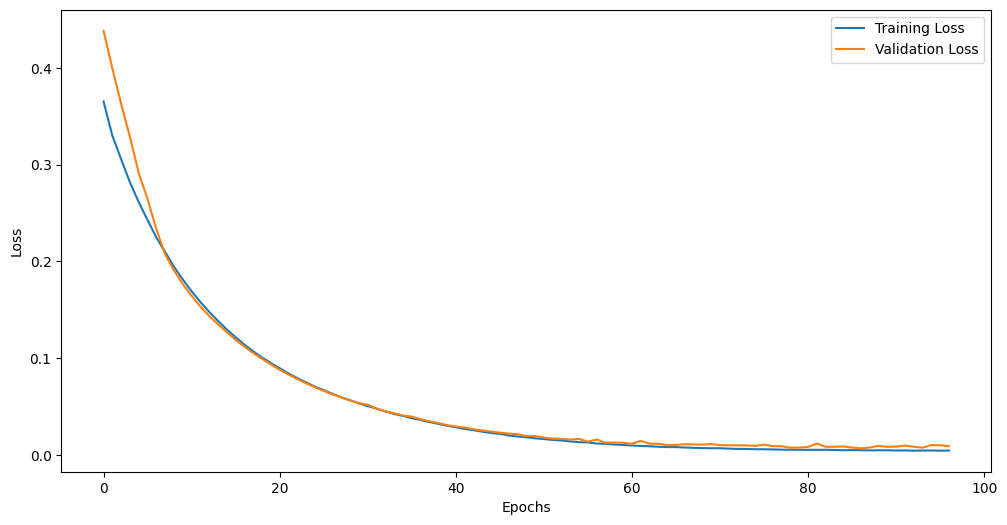

In [25]:
# Visualizing loss history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

88/88 [==============================] - 2s 13ms/step


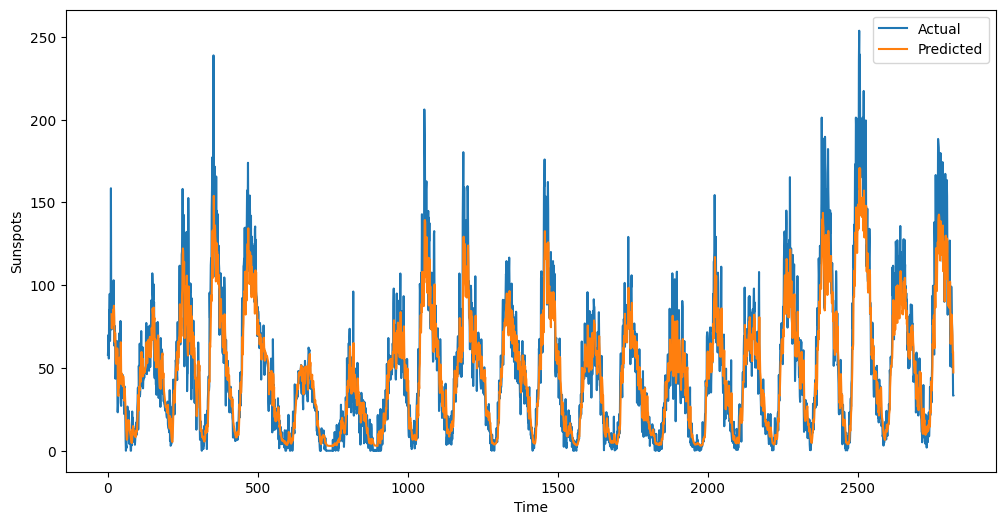

In [26]:
# Visualizing predictions
predictions = model.predict(X)
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(sunspots_scaled), label='Actual')
plt.plot(range(window_size, len(predictions) + window_size), scaler.inverse_transform(predictions), label='Predicted')
plt.xlabel('Time')
plt.ylabel('Sunspots')
plt.legend()
plt.show()